This notebook collects all the damages in the baseline and adapted conditions and calculates the expected annual damages: direct, indirect tributary, and indirect total for the network. It also compiles the adaptation costs and calculates the benefit cost ratio


In [1]:
# Imports
from ci_adapt_utilities import *
import os
import matplotlib.pyplot as plt
import math


In [ ]:
# data_path = Path(pathlib.Path.home().parts[0]) / 'Data'
data_path = Path(pathlib.Path(r'C:\Users\peregrin\OneDrive - Stichting Deltares\Documents\PhD Daniel Shared\Papers\Paper 1 - Adaptation Framework\Data\test'))
config_file=r'C:\repos\ci_adapt\config_ci_adapt_test.ini'
interim_data_path = data_path / 'interim' / 'collected_flood_runs'
adaptations_df_dir = data_path / 'interim' / 'adaptations'
basins_path = data_path.parent / r'external\hybas_eu_lev01-12_v1c\hybas_eu_lev08_v1c_valid.shp'
regions_path = data_path / r'visualisation\rhineland_palatinate.geojson'
assets, geom_dict, miraca_colors, return_period_dict, adaptation_unit_costs, rp_spec_priority, average_road_cost_per_ton_km, average_train_cost_per_ton_km, average_train_load_tons = startup_ci_adapt(data_path, config_file, interim_data_path)
shortest_paths, disrupted_edges_by_basin, graph_r0, disrupted_shortest_paths, event_impacts, full_flood_event, all_disrupted_edges, collect_output = load_baseline_impact_assessment(data_path)
event_impacts = {haz_map: event_impacts[haz_map] if haz_map in event_impacts.keys() else 0.0 for haz_map in collect_output.keys()}
direct_damages_baseline_sum = {haz_map: (sum(v[0] for v in collect_output[haz_map].values()), sum(v[1] for v in collect_output[haz_map].values())) for haz_map in collect_output}

675 assets loaded.
Loaded data from baseline impact assessment


In [3]:
increase_factors_bounds = {'lower bound':{'_H_': 2, '_M_': 1.75, '_L_': 1.82},
                            'mean':{'_H_': 2, '_M_': 4.21, '_L_': 5.86},
                            'upper bound':{'_H_': 2, '_M_': 6.67, '_L_': 9.09}}
num_years = 100
return_period_dict = {'_H_': 10,'_M_': 100,'_L_': 200}
dynamic_rps={inc_f:calculate_dynamic_return_periods(return_period_dict, num_years, increase_factors_bounds[inc_f]) for inc_f in increase_factors_bounds.keys()}

In [4]:
regions_gdf = gpd.read_file(regions_path)
basins_gdf_0 = load_basins_in_region(basins_path, regions_path, clipping=True)
basin_list_tributaries, basin_list_full_flood = find_basin_lists(basins_gdf_0)

# Find basins that have damaged assets
overlay_files = [file for file in os.listdir(interim_data_path) if file.endswith('.pkl') and file.startswith('overlay')]
basins_list = list(set([int(file.split('.')[0].split('_')[-1]) for file in overlay_files]))

In [5]:
#Calculate baseline results
adapt_id='baseline'

baseline_results_dict = {}
eadD_bl_by_ts_basin_incf = {}
eadIT_bl_by_ts_basin_incf = {}

direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)

for inc_f in increase_factors_bounds.keys():
    return_periods = dynamic_rps[inc_f] 

    ead_y0_dd_bl_all, ead_y100_dd_bl_all, total_dd_bl_all, eadD_bl_by_ts_basin_incf[inc_f] = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill)
    ead_y0_id_bl_all, ead_y100_id_bl_all, total_id_bl_all,  eadIT_bl_by_ts_basin_incf[inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill)
    ead_y0_id_bl_full, ead_y100_id_bl_full, total_id_bl_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full)

    baseline_results_dict[inc_f] = {'ead_y0_dd_bl_all': ead_y0_dd_bl_all, 'ead_y100_dd_bl_all': ead_y100_dd_bl_all, 'total_dd_bl_all': total_dd_bl_all,
                                        'ead_y0_id_bl_all': ead_y0_id_bl_all[0], 'ead_y100_id_bl_all': ead_y100_id_bl_all[0], 'total_id_bl_all': total_id_bl_all[0],
                                        'ead_y0_id_bl_full': ead_y0_id_bl_full, 'ead_y100_id_bl_full': ead_y100_id_bl_full, 'total_id_bl_full': total_id_bl_full}   

Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood


In [6]:
# Calculate results for adapted conditions
adaptation_files = [file for file in os.listdir(adaptations_df_dir) if file.endswith('.csv')]
adapt_ids = [file.split('_adaptations')[0] for file in adaptation_files]

adapted_results_dict = {}
adaptation_cost_dict = {}
eadD_ad_by_ts_basin_incf = {}
eadIT_ad_by_ts_basin_incf = {}

for adapt_id in adapt_ids:
    direct_damages_adapted, indirect_damages_adapted, indirect_damages_adapted_full, adapted_assets, adaptation_costs, adaptations_df = load_adaptation_impacts(adapt_id, data_path)
    total_damages_adapted_df_mill=process_raw_adaptations_output(direct_damages_baseline_sum, direct_damages_adapted, event_impacts, indirect_damages_adapted, adaptations_df)
    adaptation_cost_dict[adapt_id] = adaptation_costs    
    
    if adapt_id not in adapted_results_dict.keys():
        adapted_results_dict[adapt_id] = {}
        eadD_ad_by_ts_basin_incf[adapt_id] = {}
        eadIT_ad_by_ts_basin_incf[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        if inc_f not in adapted_results_dict[adapt_id]:
            adapted_results_dict[adapt_id][inc_f] = {}
        
        return_periods = dynamic_rps[inc_f]

        print(adapt_id, inc_f)

        ead_y0_dd_ad_all, ead_y100_dd_ad_all, total_dd_ad_all, eadD_ad_by_ts_basin_incf[adapt_id][inc_f]  = compile_direct_risk(inc_f, return_periods, basins_list, collect_output, total_damages_adapted_df_mill)
        
        ead_y0_id_ad_all, ead_y100_id_ad_all, total_id_ad_all, eadIT_ad_by_ts_basin_incf[adapt_id][inc_f] = compile_indirect_risk_tributaries(inc_f, return_periods, basins_list, basin_list_tributaries, collect_output, total_damages_adapted_df_mill)
        ead_y0_id_ad_full, ead_y100_id_ad_full, total_id_ad_full = compile_indirect_risk_full_flood(return_periods, indirect_damages_adapted_full)

        adapted_results_dict[adapt_id][inc_f] = {'ead_y0_dd_ad_all': ead_y0_dd_ad_all, 'ead_y100_dd_ad_all': ead_y100_dd_ad_all, 'total_dd_ad_all': total_dd_ad_all,
                                                'ead_y0_id_ad_all': ead_y0_id_ad_all[0], 'ead_y100_id_ad_all': ead_y100_id_ad_all[0], 'total_id_ad_all': total_id_ad_all[0],
                                                'ead_y0_id_ad_full': ead_y0_id_ad_full, 'ead_y100_id_ad_full': ead_y100_id_ad_full, 'total_id_ad_full': total_id_ad_full}

baseline lower bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
baseline mean
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
baseline upper bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l1_trib lower bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l1_trib mean
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l1_trib upper bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l2_trib lower bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l2_trib mean
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l2_trib upper bound
Compiling direct risk
Compiling indirect risk tributaries
Compiling indirect risk full flood
l

In [7]:
# Process adaptation costs and benefits for different levels
processed_adaptation_costs = process_adaptation_costs(adaptation_cost_dict)

# Find the avoided damages
avoided_damages_dict = {}
for adapt_id in adapt_ids:
    if adapt_id not in adapted_results_dict:
        continue
    avoided_damages_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        avoided_damages_dict[adapt_id][inc_f] = {}
        for key in baseline_results_dict[inc_f].keys():
            key_ad=key.replace('bl','ad')
            key_diff=key.replace('bl','diff')
            avoided_damages_dict[adapt_id][inc_f][key_diff] = baseline_results_dict[inc_f][key] - adapted_results_dict[adapt_id][inc_f][key_ad]

benefits_dict = {}
for adapt_id in adapt_ids:
    benefits_dict[adapt_id] = {}
    for inc_f in increase_factors_bounds.keys():
        benefits_dict[adapt_id][inc_f] = {}
        total_avoided_damages_y0 = avoided_damages_dict[adapt_id][inc_f]['ead_y0_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y0_id_diff_full']
        total_avoided_damages_y100 = avoided_damages_dict[adapt_id][inc_f]['ead_y100_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['ead_y100_id_diff_full']
        total_avoided_damages_full_period = avoided_damages_dict[adapt_id][inc_f]['total_dd_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_all'] + avoided_damages_dict[adapt_id][inc_f]['total_id_diff_full']
        benefits_dict[adapt_id][inc_f] = {'total_avoided_damages_y0': total_avoided_damages_y0, 'total_avoided_damages_y100': total_avoided_damages_y100, 'total_avoided_damages_full_period': total_avoided_damages_full_period}

In [8]:
adapt_ids=benefits_dict.keys()
bcr_df = pd.DataFrame()

for adapt_id in adapt_ids:
    for inc_f in increase_factors_bounds.keys():
        total_adaptation_cost = processed_adaptation_costs[adapt_id]
        total_avoided_damages = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period']
        bcr = total_avoided_damages / total_adaptation_cost if total_adaptation_cost != 0 else math.nan
        bcr = np.nan_to_num(bcr, nan=0)
        # bcr = bcr if bcr != math.nan else 0
        bcr_mean = bcr.mean()
        total_avoided_damages_mean = total_avoided_damages.mean()
        new_df = pd.DataFrame({(adapt_id,inc_f): [total_adaptation_cost, total_avoided_damages_mean, bcr_mean, total_avoided_damages, bcr]}, index=['total_adaptation_cost', 'total_avoided_damages_mean','bcr_mean', 'total_avoided_damages', 'bcr']).T
        bcr_df = pd.concat([bcr_df, new_df])
        
adapt_ids_paper = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib', 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']
bcr_df.sort_values('bcr_mean', ascending=False)
bcr_df = bcr_df[bcr_df.index.get_level_values(0).isin(adapt_ids_paper)].copy()

# Turn the total avoided damages and bcr columns into separate columns for the upper and lower bounds
bcr_df.loc[:, 'total_avoided_damages_lower'] = bcr_df['total_avoided_damages'].apply(lambda x: x[0])
bcr_df.loc[:, 'total_avoided_damages_upper'] = bcr_df['total_avoided_damages'].apply(lambda x: x[1])
bcr_df.loc[:, 'bcr_lower'] = bcr_df['bcr'].apply(lambda x: x[0] if np.all(x != 0) else 0)
bcr_df.loc[:, 'bcr_upper'] = bcr_df['bcr'].apply(lambda x: x[1] if np.all(x != 0) else 0)

bcr_df.to_csv(data_path / 'output' / 'bcr_df.csv')

bcr_df.head(7)    

total_adaptation_cost total_avoided_damages_mean  \
baseline lower bound                 0.000                      0.000   
         mean                        0.000                      0.000   
         upper bound                 0.000                      0.000   
l1_trib  lower bound               266.241                     31.757   
         mean                      266.241                     43.128   
         upper bound               266.241                     53.603   
l2_trib  lower bound               639.506                     96.056   

                     bcr_mean                     total_avoided_damages  \
baseline lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l1_trib  lower bound    0.119   [23.072180796251132, 40.44202295554931]   
         mean           0.162  [28.377661619827933, 57.878758347893694]   
         upper bound    0.201    [33.31626784707973, 73.88917410346536]   
l2_trib  lower bound    0.150    [87.00758564339898, 105.1047387075871]   

                                                             bcr  \
baseline lower bound                                       0.000   
         mean                                              0.000   
         upper bound                                       0.000   
l1_trib  lower bound  [0.08665912960081094, 0.15190027070147497]   
         mean         [0.10658651983518638, 0.21739266283918487]   
         upper bound  [0.12513592879111501, 0.27752779727564825]   
l2_trib  lower bound    [0.136054352253479, 0.16435299333830927]   

                      total_avoided_damages_lower  \
baseline lower bound                        0.000   
         mean                               0.000   
         upper bound                        0.000   
l1_trib  lower bound                       23.072   
         mean                              28.378   
         upper bound                       33.316   
l2_trib  lower bound                       87.008   

                      total_avoided_damages_upper  bcr_lower  bcr_upper  
baseline lower bound                        0.000      0.000      0.000  
         mean                               0.000      0.000      0.000  
         upper bound                        0.000      0.000      0.000  
l1_trib  lower bound                       40.442      0.087      0.152  
         mean                              57.879      0.107      0.217  
         upper bound                       73.889      0.125      0.278  
l2_trib  lower bound                      105.105      0.136      0.164

In [21]:
adapt_ids=benefits_dict.keys()
bcr_df = pd.DataFrame()

for adapt_id in adapt_ids:
    for inc_f in increase_factors_bounds.keys():
        total_adaptation_cost = processed_adaptation_costs[adapt_id]
        total_avoided_damages = benefits_dict[adapt_id][inc_f]['total_avoided_damages_full_period']
        bcr = total_avoided_damages / total_adaptation_cost if total_adaptation_cost != 0 else math.nan
        bcr = np.nan_to_num(bcr, nan=0)
        # bcr = bcr if bcr != math.nan else 0
        bcr_mean = bcr.mean()
        total_avoided_damages_mean = total_avoided_damages.mean()
        new_df = pd.DataFrame({(adapt_id,inc_f): [total_adaptation_cost, total_avoided_damages_mean, bcr_mean, total_avoided_damages, bcr]}, index=['total_adaptation_cost', 'total_avoided_damages_mean','bcr_mean', 'total_avoided_damages', 'bcr']).T
        bcr_df = pd.concat([bcr_df, new_df])
        
# adapt_ids_paper = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib', 'l1_rhine', 'l2_rhine', 'l3_rhine', 'l4_rhine']
adapt_ids_test = ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib']
adapt_ids_run=adapt_ids_test
bcr_df.sort_values('bcr_mean', ascending=False)
bcr_df = bcr_df[bcr_df.index.get_level_values(0).isin(adapt_ids_test)].copy()

# Turn the total avoided damages and bcr columns into separate columns for the upper and lower bounds
bcr_df.loc[:, 'total_avoided_damages_lower'] = bcr_df['total_avoided_damages'].apply(lambda x: x[0])
bcr_df.loc[:, 'total_avoided_damages_upper'] = bcr_df['total_avoided_damages'].apply(lambda x: x[1])
bcr_df.loc[:, 'bcr_lower'] = bcr_df['bcr'].apply(lambda x: x[0] if np.all(x != 0) else 0)
bcr_df.loc[:, 'bcr_upper'] = bcr_df['bcr'].apply(lambda x: x[1] if np.all(x != 0) else 0)

bcr_df.to_csv(data_path / 'output' / 'bcr_df.csv')

bcr_df    

total_adaptation_cost total_avoided_damages_mean  \
baseline lower bound                 0.000                      0.000   
         mean                        0.000                      0.000   
         upper bound                 0.000                      0.000   
l1_trib  lower bound               266.241                     31.757   
         mean                      266.241                     43.128   
         upper bound               266.241                     53.603   
l2_trib  lower bound               639.506                     96.056   
         mean                      639.506                    141.860   
         upper bound               639.506                    183.862   
l3_trib  lower bound               213.091                     88.535   
         mean                      213.091                    118.095   
         upper bound               213.091                    145.524   
l4_trib  lower bound                 0.000                      0.669   
         mean                        0.000                      0.929   
         upper bound                 0.000                      1.169   

                     bcr_mean                     total_avoided_damages  \
baseline lower bound    0.000                                [0.0, 0.0]   
         mean           0.000                                [0.0, 0.0]   
         upper bound    0.000                                [0.0, 0.0]   
l1_trib  lower bound    0.119   [23.072180796251132, 40.44202295554931]   
         mean           0.162  [28.377661619827933, 57.878758347893694]   
         upper bound    0.201    [33.31626784707973, 73.88917410346536]   
l2_trib  lower bound    0.150    [87.00758564339898, 105.1047387075871]   
         mean           0.222    [126.5955216440434, 157.1234817618448]   
         upper bound    0.288  [162.92449707955876, 204.79980835645875]   
l3_trib  lower bound    0.415    [88.53458504331171, 88.53458504331171]   
         mean           0.554  [118.09543470437069, 118.09543470437069]   
         upper bound    0.683  [145.52369853328858, 145.52369853328858]   
l4_trib  lower bound    0.000  [0.6688861926964904, 0.6688861926964904]   
         mean           0.000  [0.9293189325732385, 0.9293189325732385]   
         upper bound    0.000  [1.1689112670545398, 1.1689112670545398]   

                                                             bcr  \
baseline lower bound                                       0.000   
         mean                                              0.000   
         upper bound                                       0.000   
l1_trib  lower bound  [0.08665912960081094, 0.15190027070147497]   
         mean         [0.10658651983518638, 0.21739266283918487]   
         upper bound  [0.12513592879111501, 0.27752779727564825]   
l2_trib  lower bound    [0.136054352253479, 0.16435299333830927]   
         mean          [0.19795827648940553, 0.2456950549407752]   
         upper bound   [0.2547661419687367, 0.32024685045020085]   
l3_trib  lower bound    [0.4154774461457313, 0.4154774461457313]   
         mean           [0.5542013845599264, 0.5542013845599264]   
         upper bound    [0.6829174676846762, 0.6829174676846762]   
l4_trib  lower bound                                       0.000   
         mean                                              0.000   
         upper bound                                       0.000   

                      total_avoided_damages_lower  \
baseline lower bound                        0.000   
         mean                               0.000   
         upper bound                        0.000   
l1_trib  lower bound                       23.072   
         mean                              28.378   
         upper bound                       33.316   
l2_trib  lower bound                       87.008   
         mean                             126.596   
         upper bound                      162.924   
l3_trib  lower bound            

In [10]:
# Find adaptations with BCR greater than 1 under all increase factors
adaptations_with_bcr_greater_than_1 = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1.append(adapt_id)
print(f'No-regret: Adaptations with BCR greater than 1 under all increase factors: {adaptations_with_bcr_greater_than_1}')

# Find adaptations with BCR greater than 1 in at least one increase factor but not all 3
adaptations_with_bcr_greater_than_1_some = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if any(bcr > 1 for bcr in bcr_values) and not all(bcr > 1 for bcr in bcr_values):
        adaptations_with_bcr_greater_than_1_some.append(adapt_id)
print(f'Adaptations with BCR greater than 1 in at least one increase factor but not all 3: {adaptations_with_bcr_greater_than_1_some}')

# Find adaptations with BCR less than 1 in all increase factors
adaptations_with_bcr_less_than_1 = []
for adapt_id in adapt_ids_run:
    bcr_values = bcr_df.loc[adapt_id]['bcr_mean']
    if all(bcr < 1 for bcr in bcr_values):
        adaptations_with_bcr_less_than_1.append(adapt_id)
print(f'Economically inefficient: Adaptations with BCR less than 1 in all increase factors: {adaptations_with_bcr_less_than_1}')

No-regret: Adaptations with BCR greater than 1 under all increase factors: []
Adaptations with BCR greater than 1 in at least one increase factor but not all 3: []
Economically inefficient: Adaptations with BCR less than 1 in all increase factors: ['baseline', 'l1_trib', 'l2_trib', 'l3_trib', 'l4_trib']


In [22]:
# Create a DataFrame with the benefits for each adaptation and increase factor by appending each new Series to the previous one
avoided_damages_df = pd.DataFrame()
for adapt_id in adapt_ids_run:
    for inc_f in increase_factors_bounds.keys():
        new_df = pd.Series(avoided_damages_dict[adapt_id][inc_f], name=(adapt_id, inc_f))
        avoided_damages_df = pd.concat([avoided_damages_df, new_df], axis=1)


avoided_damages_df = avoided_damages_df.T

avoided_damages_df.columns = ['Avoided Direct Y0 [M€/y]', 'Avoided Direct Y100 [M€/y]', 'Avoided Direct Total [M€]', 'Avoided Indirect Tributaries Y0 [M€/y]', 'Avoided Indirect Tributaries Y100 [M€/y]', 'Avoided Indirect Tributaries Total [M€]', 'Avoided Indirect Full Flood Y0 [M€/y]', 'Avoided Indirect Full Flood Y100 [M€/y]', 'Avoided Indirect Full Flood Total [M€]']
avoided_damages_df.index.names = ['Adaptation, Climate Change Increase Factor']

avoided_damages_df.to_csv(data_path / 'output' / 'avoided_damages_df.csv')
avoided_damages_df

,Avoided Direct Y0 [M€/y],Avoided Direct Y100 [M€/y],Avoided Direct Total [M€],Avoided Indirect Tributaries Y0 [M€/y],Avoided Indirect Tributaries Y100 [M€/y],Avoided Indirect Tributaries Total [M€],Avoided Indirect Full Flood Y0 [M€/y],Avoided Indirect Full Flood Y100 [M€/y],Avoided Indirect Full Flood Total [M€]
"Adaptation, Climate Change Increase Factor",,,,,,,,,
"(baseline, lower bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, mean)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(baseline, upper bound)","[0.0, 0.0]","[0.0, 0.0]","[0.0, 0.0]",0.000,0.000,0.000,0.000,0.000,0.000
"(l1_trib, lower bound)","[0.06795927397899033, 0.19065049132756517]","[0.10953407535512273, 0.33080012848769996]","[8.96341414137271, 26.33325630067089]",0.046,0.093,7.054,0.046,0.093,7.054
"(l1_trib, mean)","[0.06795927397899033, 0.19065049132756517]","[0.23432047826568433, 0.6958093941461336]","[15.265127488356073, 44.76622421642183]",0.046,0.083,6.556,0.046,0.083,6.556
"(l1_trib, upper bound)","[0.06795927397899033, 0.19065049132756517]","[0.34789357127225, 1.0286262401887374]","[21.000568685187645, 61.57347494157328]",0.046,0.075,6.158,0.046,0.075,6.158
"(l2_trib, lower bound)","[0.10922136288444839, 0.2371058685725254]","[0.17524984448056596, 0.40572480541007533]","[14.365795971933224, 32.46294903612134]",0.249,0.470,36.321,0.249,0.470,36.321
"(l2_trib, mean)","[0.10922136288444839, 0.2371058685725254]","[0.37637444778711304, 0.8530040038376762]","[24.522588438913854, 55.05054855671523]",0.249,0.761,51.036,0.249,0.761,51.036
"(l2_trib, upper bound)","[0.10922136288444839, 0.2371058685725254]","[0.5593783140131775, 1.26070789301619]","[33.7642836833301, 75.63959496023011]",0.249,1.029,64.580,0.249,1.029,64.580


In [13]:
od_geoms = get_od_geoms_from_sps(shortest_paths, graph_r0)
od_geoms_plot= gpd.GeoDataFrame(od_geoms)
od_geoms_plot.crs = 'EPSG:3857'
od_geoms_gdf = od_geoms_plot.to_crs('EPSG:4326')
od_geoms_plot.to_file(data_path / 'output' / 'od_geoms_plot.geojson', driver='GeoJSON')

In [14]:
shortest_paths_assets = get_asset_ids_from_sps(shortest_paths, graph_r0)

In [15]:
basins_gdf = basins_gdf_0.copy()

# Extract the geometries of the stretches of disrupted rail track
rp_defs = ['L', 'M', 'H']
disrupted_asset_ids = {rp_def: [] for rp_def in rp_defs}
for rp_def in rp_defs:
    for hazard_map, asset_dict in collect_output.items():
        rp = hazard_map.split('_RW_')[-1].split('_')[0]
        if rp != rp_def:
            continue

        overlay_assets = load_baseline_run(hazard_map, interim_data_path, only_overlay=True)
        disrupted_asset_ids[rp_def].extend(overlay_assets.asset.unique())

# Filter out assets that are bridges or tunnels
disrupted_asset_ids_filt = {rp_def: [] for rp_def in rp_defs}
for rp_def, asset_ids in disrupted_asset_ids.items():
    for asset_id in asset_ids:
        if assets.loc[asset_id, 'bridge'] is None and assets.loc[asset_id, 'tunnel'] is None:
            disrupted_asset_ids_filt[rp_def].append(asset_id)

# Prepare gdf for plotting
basins_gdf = basins_gdf_0[basins_gdf_0['HYBAS_ID'].isin(eadD_bl_by_ts_basin_incf['mean'].keys())].copy()
basin_list=basins_gdf.HYBAS_ID.values.tolist()

basins_gdf['Average EAD_D_bl_t0'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[0].mean() for basin in basin_list]
basins_gdf['Average EAD_D_bl_t100'] = [eadD_bl_by_ts_basin_incf['mean'][basin].values[-1].mean() for basin in basin_list]
basins_gdf['EAD_ID_bl_t0'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[0][0] for basin in basin_list]
basins_gdf['EAD_ID_bl_t100'] = [0.0 if not basin in eadIT_bl_by_ts_basin_incf['mean'].keys() else eadIT_bl_by_ts_basin_incf['mean'][basin].values[-1][0] for basin in basin_list]

basins_gdf_reduced = basins_gdf[['HYBAS_ID', 'geometry', 'Average EAD_D_bl_t0', 'Average EAD_D_bl_t100', 'EAD_ID_bl_t0', 'EAD_ID_bl_t100']]
basins_gdf_reduced.head(3)

,HYBAS_ID,geometry,Average EAD_D_bl_t0,Average EAD_D_bl_t100,EAD_ID_bl_t0,EAD_ID_bl_t100
29,2080430320,"POLYGON ((7.91667 49.88750, 7.91424 49.88785, ...",0.175,0.623,0.249,0.762


In [16]:
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import matplotlib as mpl

#Plotting prep
dic_colors = {'H': '#f03b20', 'M': '#feb24c', 'L': '#ffeda0'}
main_basin_list = basin_list_full_flood - set(basin_list_tributaries)
assets_4326_clipped = gpd.clip(assets.to_crs(4326), regions_gdf)
basins_gdf_reduced_clipped = gpd.clip(basins_gdf_reduced, regions_gdf)
# Set the font colors
default_mpl_color = miraca_colors['grey_900']
mpl.rcParams['text.color'] = default_mpl_color
mpl.rcParams['axes.labelcolor'] = default_mpl_color
mpl.rcParams['xtick.color'] = default_mpl_color
mpl.rcParams['ytick.color'] = default_mpl_color

fontsize_set = {
    'large': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16},
    'small': {'title': 24, 'label': 24, 'legend': 18, 'ticks': 16, 'legend_title': 18, 'legend_label': 18, 'suptitle': 12},
    'default_miraca': {'title': 42, 'label': 38, 'legend': 20, 'ticks': 28, 'legend_title': 20, 'legend_label': 20, 'suptitle': 16}
}

mainfont = {'fontname': 'Arial'}
#mainfont = {'fontname': 'Space Grotesk'}
basefont = {'fontname': 'Calibri'}

# Define the size set to use
size_set = fontsize_set['small']  # Change to 'large' or 'small' as needed

ValueError: aspect must be finite and positive 

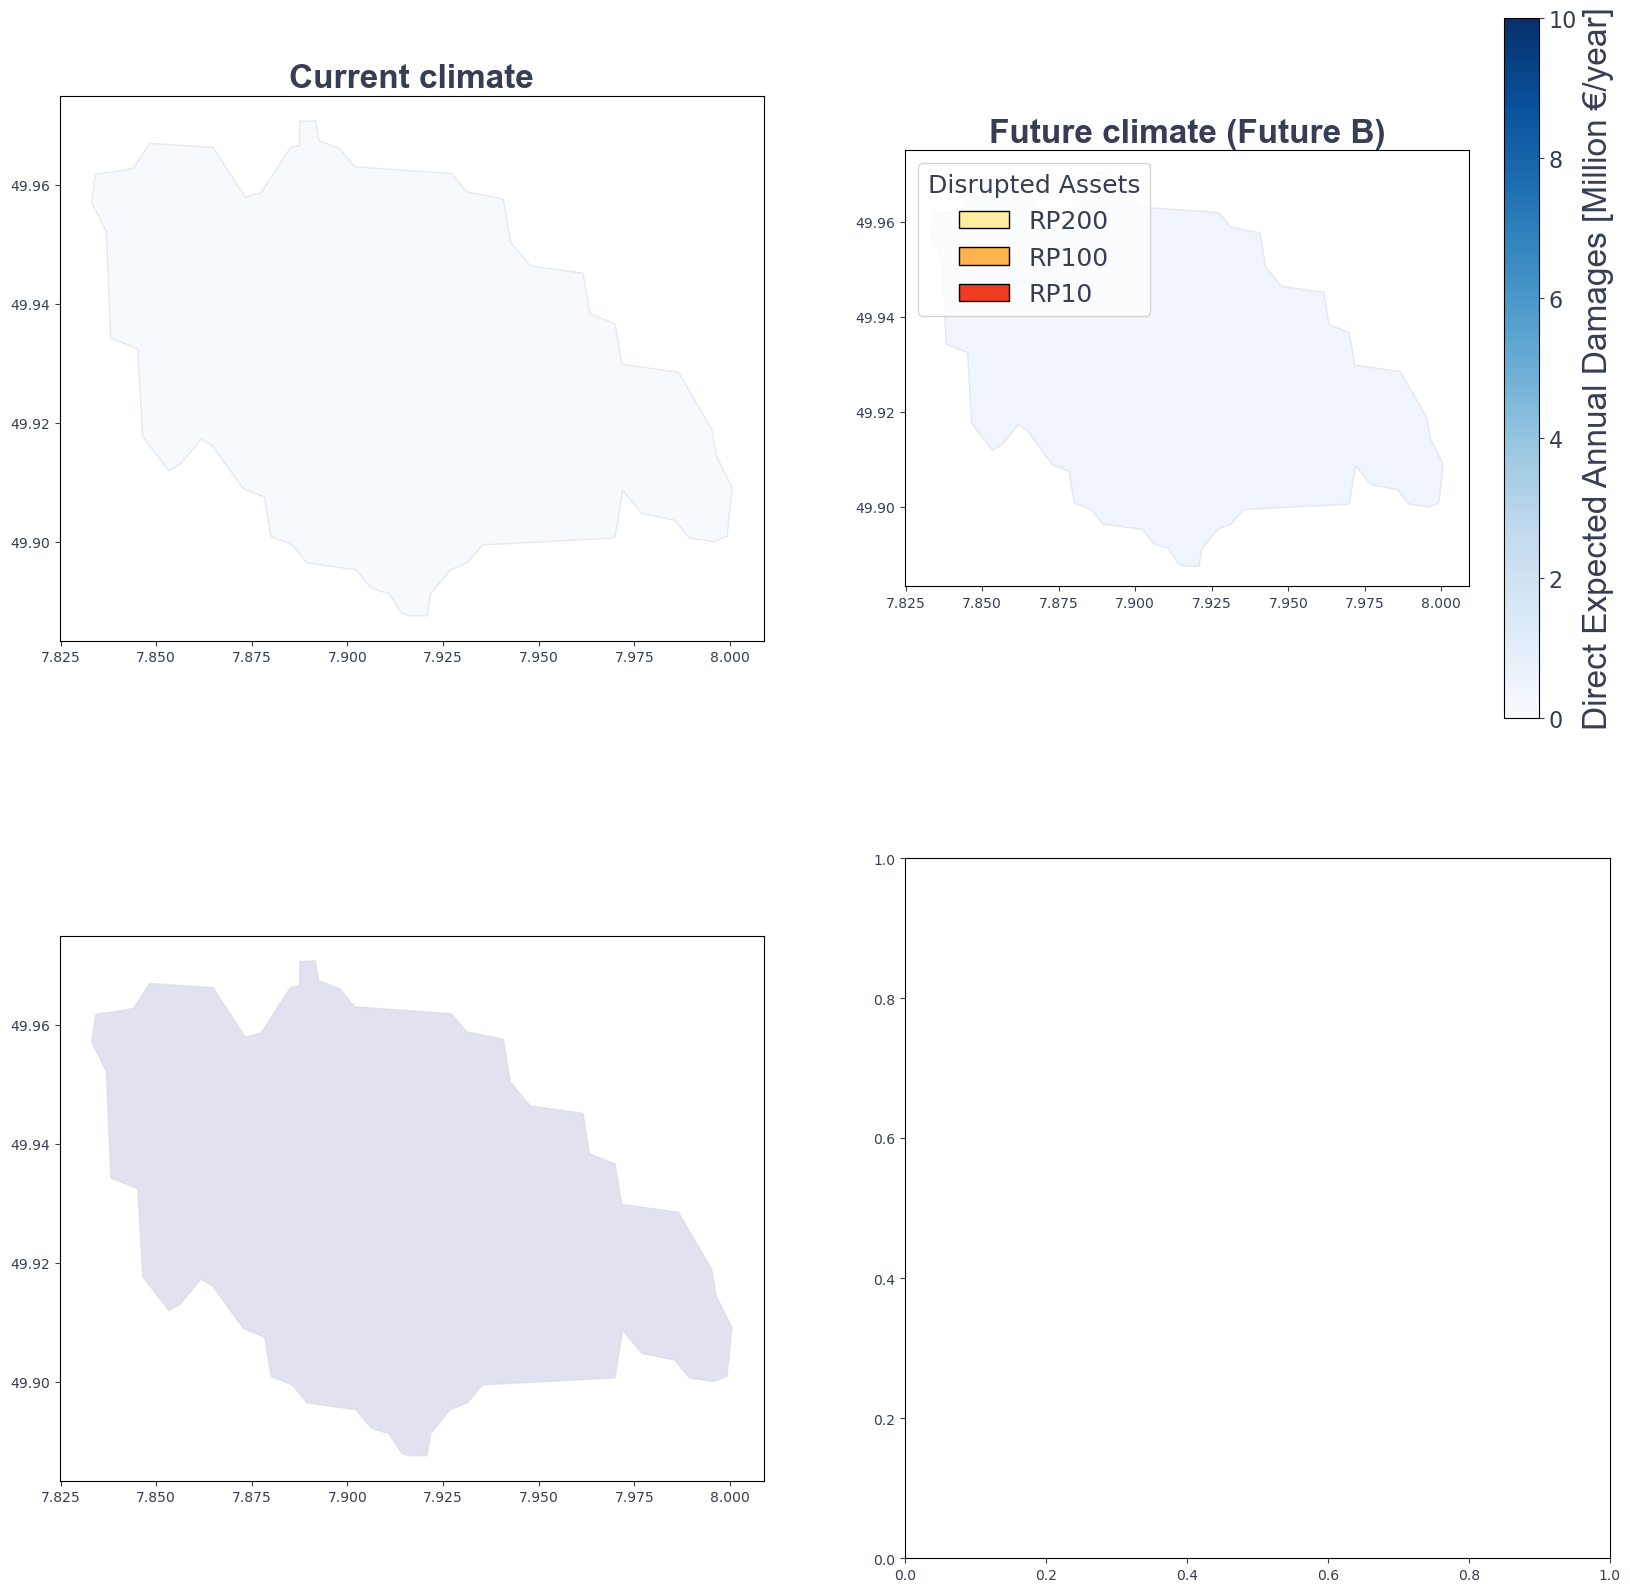

In [17]:
# Plot only with full dataset
# Plot
fig, axs = plt.subplots(2, 2, figsize=(20, 20))
# Direct damages
# Plot for year 0
ax = 0, 0
vmax_dd = math.ceil(max([eadD_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadD_bl_by_ts_basin_incf['mean']]) / 10.0) * 10
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t0', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Current climate', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Plot for year 100
ax = 0, 1
valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
basins_gdf_reduced_clipped.plot(column='Average EAD_D_bl_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
axs[ax].set_title('Future climate (Future B)', fontsize=size_set['title'], fontweight='bold', **mainfont)
# Add color bar and legend
sm1 = plt.cm.ScalarMappable(cmap='Blues', norm=plt.Normalize(vmin=0, vmax=vmax_dd))
cbar1 = plt.colorbar(sm1, ax=axs[ax])
cbar1.set_label('Direct Expected Annual Damages [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar1.ax.tick_params(labelsize=size_set['ticks'])
rp_letter_equiv = {'H': 'RP10', 'M': 'RP100', 'L': 'RP200'}
legend_elements = [mpatches.Patch(facecolor=dic_colors[rp_def], edgecolor='k', label=rp_letter_equiv[rp_def]) for rp_def in disrupted_asset_ids_filt.keys()]
axs[ax].legend(handles=legend_elements, title='Disrupted Assets', loc='upper left', fontsize=size_set['legend_label'], title_fontsize=size_set['legend_title'])
plt.setp(axs[ax].texts, family='Space Grotesk')

# Indirect losses, tributary basins
# Plot for year 0
ax = 1, 0
vmax_id = np.ceil(max([eadIT_bl_by_ts_basin_incf['mean'][basin].values[0].max() for basin in eadIT_bl_by_ts_basin_incf['mean']]))
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t0', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Plot for year 100
ax = 1, 1
basins_gdf_reduced_clipped.plot(column='EAD_ID_bl_t100', ax=axs[ax], legend=False, cmap='Purples', vmin=0, vmax=vmax_id, alpha=0.8)
basins_gdf_reduced_clipped.plot(ax=axs[ax], edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
basins_gdf_reduced_clipped[basins_gdf_reduced_clipped['HYBAS_ID'].isin(main_basin_list)].plot(ax=axs[ax], edgecolor='None', facecolor=miraca_colors['grey_500'], alpha=0.5, linewidth=1, hatch='//')
axs[ax].set_title(' ', fontsize=size_set['title'])
# Add color bar
sm2 = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=vmax_id))
cbar2 = plt.colorbar(sm2, ax=axs[ax], ticks=[0, 1, 2, 3])
cbar2.set_label('Indirect Expected Annual Losses [Million €/year]', fontsize=size_set['label'], **mainfont)
cbar2.ax.tick_params(labelsize=size_set['ticks'])

# Plot static content
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], lw=2)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], lw=3)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)
    ax.set_axis_off()

# Label as A, B, C, D in the bottom right corner with a grey background and black text
for i, ax in enumerate(axs.flat):
    ax.text(0.98, 0.05, f' {chr(65+i)} ', transform=ax.transAxes, fontsize=size_set['title'], fontweight='regular', color='black', ha='center', va='center', bbox=dict(facecolor='lightgrey', edgecolor='black', boxstyle='square,pad=0.2'))
plt.tight_layout()
plt.suptitle('Direct and Indirect Damages and Losses at Year 0 and 100 (Future B) [Baseline]', fontsize=size_set['suptitle'], fontweight='bold', y=1.03, **basefont)
plt.text(0, -0.1, f'Adaptation: No adaptation', ha='center', va='bottom', fontsize=size_set['suptitle'], transform=plt.gca().transAxes, **basefont)

plt.show()

In [18]:
# Save the exposed assets to a GeoJSON file
for rp_def, asset_ids in disrupted_asset_ids_filt.items():
    valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
    assets_4326_clipped.loc[valid_asset_ids].to_file(data_path / 'output' / 'impacts' / f'exposed_assets_{rp_def}.geojson', driver='GeoJSON')

output_disruption_summary_path = data_path / 'output' / 'disruption_summary.csv'
calculate_disruption_summary(disrupted_asset_ids_filt, assets_4326_clipped, assets, save_to_csv=True, output_path=output_disruption_summary_path)

Total exposed assets: 30
Total assets: 537
Fraction of disrupted assets: 0.06
Fraction of disrupted asset by length: 0.07


Applying adaptation: new connection between assets with osm_id  (4424116, 219651487)
Level 3 adaptation
Applying adaptation: new connection between assets with osm_id  (219651487, 111997047)
Level 3 adaptation
Applying adaptation: reduced demand for routes:  [('node_682', 'node_684'), ('node_684', 'node_682'), ('node_260', 'node_387'), ('node_387', 'node_260'), ('node_387', 'node_434'), ('node_387', 'node_286'), ('node_434', 'node_387'), ('node_286', 'node_387')]
Level 4 adaptation


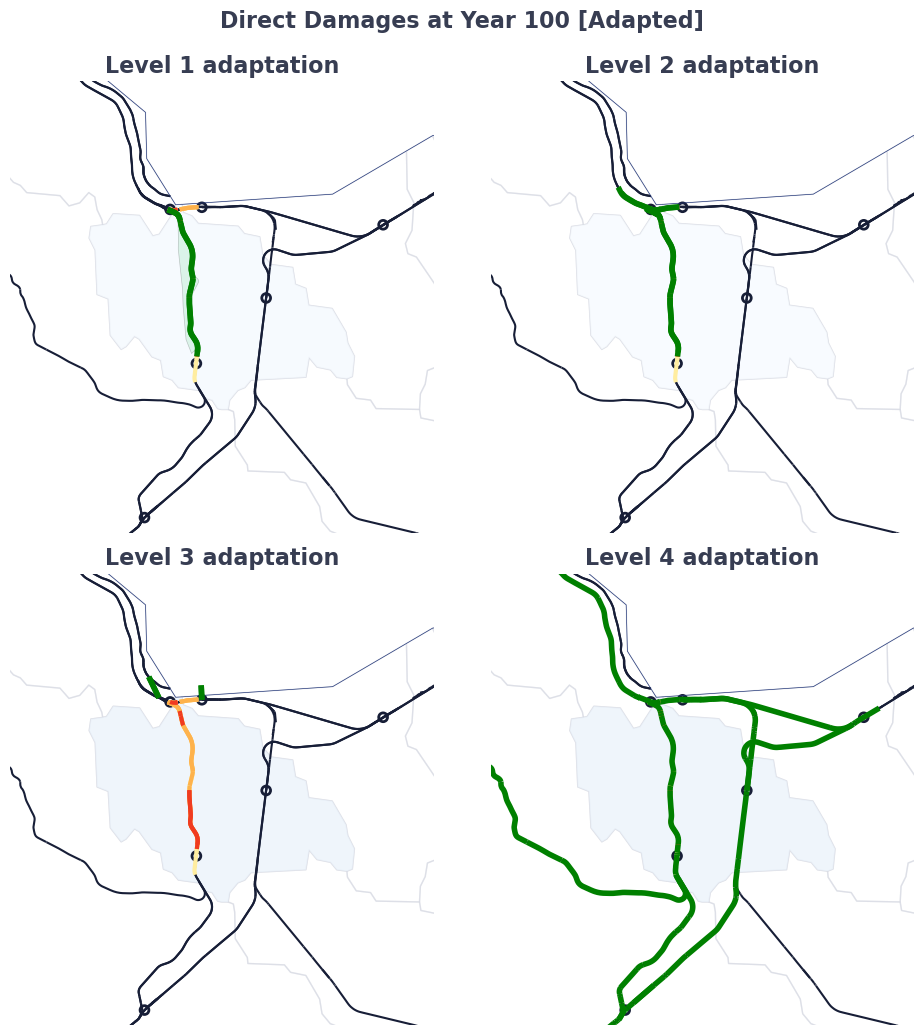

In [19]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Find value max for color bars assuming baseline conditions have higher damages than adapted conditions
baseline_basins_gdf = prep_adapted_basins_gdf(basins_gdf_0, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='baseline', inc_f='mean', clipping_gdf=regions_gdf)
vmax_dd = math.ceil(max([baseline_basins_gdf['Average EAD_D_ad_t0'].max(), baseline_basins_gdf['Average EAD_D_ad_t100'].max()]) / 10.0) * 10
vmax_id = np.ceil(max([baseline_basins_gdf['EAD_ID_ad_t0'].max(), baseline_basins_gdf['EAD_ID_ad_t100'].max()])) 
adapted_basins_list = find_adapted_basin(eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='l1_trib')
# xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID']==2080430320].total_bounds
xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID'].isin(adapted_basins_list)].total_bounds
buffer = 0.05
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Plot standard elements for all subplots
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], markersize=1)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], markersize=2, linewidth=3)
    baseline_basins_gdf.plot(ax=ax, edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)

    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)    

# Level 1 adaptation
# Plot for year 100
ax = 0, 0
adapt_id = 'l1_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 1 adaptation', fontsize=16, fontweight='bold')
# kevel 1 adaptation is a gdf of the protected area and a filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l1_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
gdf_prot_area.plot(ax=axs[ax], edgecolor='black', facecolor=miraca_colors['green_success'], alpha=0.2, linewidth=0.5)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l1_tributary_assets.geojson', driver='GeoJSON')

# Level 2 adaptation
# Plot for year 100
ax = 0, 1
adapt_id = 'l2_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 2 adaptation', fontsize=16, fontweight='bold')
# level 2 adaptation is a gdf of the filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l2_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l2_tributary_assets.geojson', driver='GeoJSON')

# Level 3 adaptation
# Plot for year 100
ax = 1, 0
adapt_id = 'l3_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 3 adaptation', fontsize=16, fontweight='bold')
# level 3 adaptation is a gdf of new connections between the protected assets
added_links = [(4424116, 219651487), (219651487, 111997047)]
for i,osm_id_pair in enumerate(added_links):
        graph_v, _ = add_l3_adaptation(graph_r0, osm_id_pair)
gdf_l3_edges = get_l3_gdf(added_links, graph_v)
gdf_l3_edges.plot(ax=axs[ax], color='green', lw=4)
gdf_l3_edges.to_file(data_path / 'output' / 'adaptations' / 'l3_tributary_edges.geojson', driver='GeoJSON')

# Level 4 adaptation
# Plot for year 100
ax = 1, 1
adapt_id = 'l4_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 4 adaptation', fontsize=16, fontweight='bold')
# level 4 adaptation is a gdf with the assets in shortest paths with reduced demand
adapted_route_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l4_tributary.geojson')
demand_reduction_dict = add_l4_adaptation(graph_r0, shortest_paths, adapted_route_area.to_crs(3857))   
assets_in_paths = list(set([asset_id for od, (asset_ids, demand) in get_asset_ids_from_sps(shortest_paths, graph_r0).items() for asset_id in asset_ids if asset_id != '']))
assets_adapt=assets_4326_clipped[assets_4326_clipped['osm_id'].isin(assets_in_paths)]
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l4_tributary_assets.geojson', driver='GeoJSON')

for ax in axs.flat:
    od_geoms_plot.to_crs(4326).plot(ax=ax, edgecolor=miraca_colors['black'], facecolor="None", markersize=40, linewidth=2)

plt.tight_layout()
plt.suptitle('Direct Damages at Year 100 [Adapted]', fontsize=16,
             fontweight='bold',
             y=1.03)

plt.show()

Applying adaptation: new connection between assets with osm_id  (4424116, 219651487)
Level 3 adaptation
Applying adaptation: new connection between assets with osm_id  (219651487, 111997047)
Level 3 adaptation
Applying adaptation: reduced demand for routes:  [('node_682', 'node_684'), ('node_684', 'node_682'), ('node_260', 'node_387'), ('node_387', 'node_260'), ('node_387', 'node_434'), ('node_387', 'node_286'), ('node_434', 'node_387'), ('node_286', 'node_387')]
Level 4 adaptation


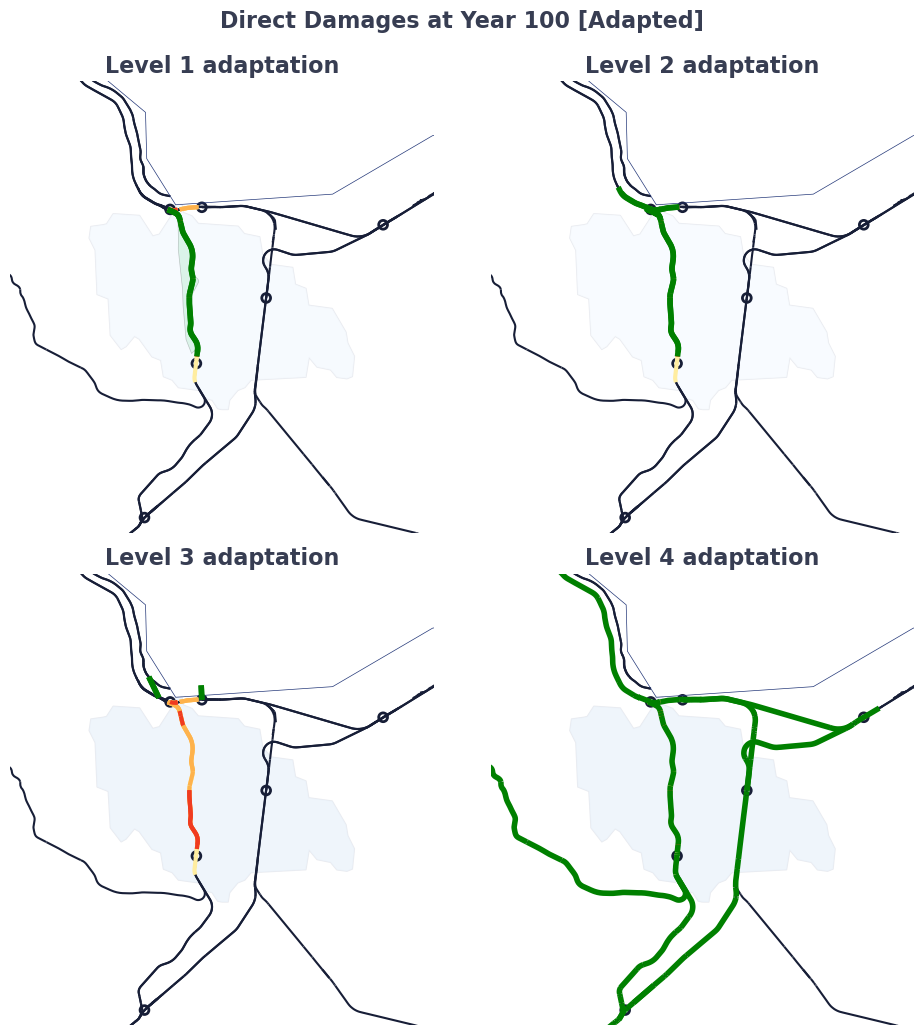

In [20]:
# Plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))

# Find value max for color bars assuming baseline conditions have higher damages than adapted conditions
baseline_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='baseline', inc_f='mean', clipping_gdf=regions_gdf)
vmax_dd = math.ceil(max([baseline_basins_gdf['Average EAD_D_ad_t0'].max(), baseline_basins_gdf['Average EAD_D_ad_t100'].max()]) / 10.0) * 10
vmax_id = np.ceil(max([baseline_basins_gdf['EAD_ID_ad_t0'].max(), baseline_basins_gdf['EAD_ID_ad_t100'].max()])) 
adapted_basins_list = find_adapted_basin(eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id='l4_trib')
# xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID']==2080430320].total_bounds
xmin, ymin, xmax, ymax = basins_gdf[basins_gdf['HYBAS_ID'].isin(adapted_basins_list)].total_bounds
buffer = 0.05
xmin -= buffer
ymin -= buffer
xmax += buffer
ymax += buffer

# Plot standard elements for all subplots
for ax in axs.flat:
    assets_4326_clipped.plot(ax=ax, color=miraca_colors['black'], markersize=1)
    for rp_def, asset_ids in disrupted_asset_ids_filt.items():
        valid_asset_ids = [asset_id for asset_id in asset_ids if asset_id in assets_4326_clipped.index]
        assets_4326_clipped.loc[valid_asset_ids].plot(ax=ax, color=dic_colors[rp_def], markersize=2, linewidth=3)
    baseline_basins_gdf.plot(ax=ax, edgecolor=miraca_colors['grey_200'], facecolor="None", alpha=0.5, linewidth=1)
    regions_gdf.boundary.plot(ax=ax, edgecolor=miraca_colors['blue_900'], linestyle='-', linewidth=0.5)

    ax.set_axis_off()
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)    

# Level 1 adaptation
# Plot for year 100
ax = 0, 0
adapt_id = 'l1_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 1 adaptation', fontsize=16, fontweight='bold')
# kevel 1 adaptation is a gdf of the protected area and a filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l1_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
gdf_prot_area.plot(ax=axs[ax], edgecolor='black', facecolor=miraca_colors['green_success'], alpha=0.2, linewidth=0.5)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l1_trib_assets.geojson', driver='GeoJSON')

# Level 2 adaptation
# Plot for year 100
ax = 0, 1
adapt_id = 'l2_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 2 adaptation', fontsize=16, fontweight='bold')
# level 2 adaptation is a gdf of the filter of the protected assets
gdf_prot_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l2_tributary.geojson')
assets_adapt=filter_assets_to_adapt(assets_4326_clipped.to_crs(3857), gdf_prot_area.to_crs(3857))
assets_adapt=assets_adapt.to_crs(4326)
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l2_trib_assets.geojson', driver='GeoJSON')

# Level 3 adaptation
# Plot for year 100
ax = 1, 0
adapt_id = 'l3_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 3 adaptation', fontsize=16, fontweight='bold')
# level 3 adaptation is a gdf of new connections between the protected assets
added_links = [(4424116, 219651487), (219651487, 111997047)]
for i,osm_id_pair in enumerate(added_links):
        graph_v, _ = add_l3_adaptation(graph_r0, osm_id_pair)
gdf_l3_edges = get_l3_gdf(added_links, graph_v)
gdf_l3_edges.plot(ax=axs[ax], color='green', lw=4)
gdf_l3_edges.to_file(data_path / 'output' / 'adaptations' / 'l3_trib_edges.geojson', driver='GeoJSON')

# Level 4 adaptation
# Plot for year 100
ax = 1, 1
adapt_id = 'l4_trib'
adapted_basins_gdf = prep_adapted_basins_gdf(basins_gdf, eadD_ad_by_ts_basin_incf, eadIT_ad_by_ts_basin_incf, adapt_id=adapt_id, inc_f='mean', clipping_gdf=regions_gdf)
adapted_basins_gdf.plot(column='Average EAD_D_ad_t100', ax=axs[ax], legend=False, cmap='Blues', vmin=0, vmax=vmax_dd, alpha=0.8)
axs[ax].set_title('Level 4 adaptation', fontsize=16, fontweight='bold')
# level 4 adaptation is a gdf with the assets in shortest paths with reduced demand
adapted_route_area = gpd.read_file(data_path / 'input' / 'adaptations' /  'l4_tributary.geojson')
demand_reduction_dict = add_l4_adaptation(graph_r0, shortest_paths, adapted_route_area.to_crs(3857))   
assets_in_paths = list(set([asset_id for od, (asset_ids, demand) in get_asset_ids_from_sps(shortest_paths, graph_r0).items() for asset_id in asset_ids if asset_id != '']))
assets_adapt=assets_4326_clipped[assets_4326_clipped['osm_id'].isin(assets_in_paths)]
assets_adapt.plot(ax=axs[ax], color='green', lw=4)
assets_adapt.to_file(data_path / 'output' / 'adaptations' / 'l4_trib_assets.geojson', driver='GeoJSON')

for ax in axs.flat:
    od_geoms_plot.to_crs(4326).plot(ax=ax, edgecolor=miraca_colors['black'], facecolor="None", markersize=40, linewidth=2)

plt.tight_layout()
plt.suptitle('Direct Damages at Year 100 [Adapted]', fontsize=16,
             fontweight='bold',
             y=1.03)

plt.show()